In [1]:
import numpy as np
import scipy.optimize as opt
from icecream import ic
import logging
import time
import matplotlib.pyplot as plt
import create_grids, create_polynomials, compute_MC_Residual_Histogram, compute_MC_Residual_Poly, compute_moments

The calibration portion of the replication exercise heavily follows Winberry 2018

First we set the model parameters:

In [2]:
# preferences
beta = .96 # discount rate
sigma = 1 # CRRA
a_bar = 0 # borrowing constraint

#tech
alpha = .36 # capital share
delta = .1  # depreciation

#idiosyncratic shocks
epsilon_grid = np.array([0,1]).reshape((1,2)) #idiosyncratic shocks
N = .93 # Aggregate employment
u_duration = 1
frac_u = u_duration/(1+u_duration)
frac_N = (1-N)/N
epsilon_transition_mat = np.array([frac_u,1-frac_u,frac_N*(1-frac_u),1-(frac_N*(1-frac_u)) ]).reshape((2,2))
epsilon_invariant = np.array([1-N,N]).reshape((2,1))

#unemployment benefits
mu = .15
tau = mu*frac_N

#Aggregate Shocks
rho_TFP = .859
sigma_TFP = .014


Next we set the parameters that control the approximations (chebyshev and distribution):


In [26]:
#Approximation Parameters
n_epsilon = 2 # number of shocks
n_assets = 25  # number of gridpoints for use in asset grid/polynomial interpolation
n_states = n_epsilon*n_assets

#Bounds on Grid space
K_rep_SS = ((alpha*(N**(1-alpha)))/((1/beta)-(1-delta)))**(1/(1-alpha)) #from firm capital FOC
assets_min = a_bar
assets_max = 3*K_rep_SS #ad-hoc

#Finger grid for analyzing policy funcs/histograms
n_assets_fine = 100
n_states_fine = n_epsilon*n_assets_fine

#Degree Approx of distribution for integrating over via quadrature rule
n_measure = 3
n_assets_quad = 8 # number of interpolant points to use for quadrature
n_states_quad = n_epsilon*n_assets_quad
n_measure_coeff = n_epsilon*n_measure

# Optimization params
max_iter = 2e3
tol = 1e-5
damp = .95

## Solving the Steady State

We begin solving for the steady state of the file. First we construct the grids we need (there are many) using the `create_grids` function.

In [27]:
tic = time.perf_counter()
[   
    asset_cheb_zeros, 
    assets_grid,
    epsilon_mat_grid,
    assets_mat_grid,
    epsilon_grid_prime, 
    assets_grid_fine,
    assets_grid_fine_zeros,
    epsilon_mat_grid_fine,
    assets_mat_grid_fine,
    epsilon_grid_prime_fine,
    assets_grid_quad_zeros,
    quad_weights,
    assets_grid_quad,
    epsilon_grid_mat_quad,
    assets_grid_mat_quad
    ] = create_grids.create_grids(
                                    n_assets,
                                n_assets_fine,
                                n_epsilon,
                                assets_min,
                                assets_max,
                                n_states,
                                n_states_fine,
                                n_assets_quad,
                                epsilon_grid
                                            )
toc = time.perf_counter()
print("{:f} μs".format((toc-tic)*1000)) #5x speedup even without using compiler


2.502246 μs


Next we construct the chebyshev polynomials on the grid of interest

In [5]:
tic = time.perf_counter()
[ assets_poly,
        assets_poly_sq,
        assets_poly_fine,
        assets_poly_quad,
        assets_poly_BC]=create_polynomials.compute_poly(n_assets,asset_cheb_zeros,assets_grid_fine_zeros, assets_grid_quad_zeros )
toc = time.perf_counter()
print("{:f} μs".format((toc-tic)*1000))

1.919933 μs


Finally, we begin the process of computing the steady state objects of interest. 

We compute an initial guess of market clearing capital stock using a histogram approx of distribution following (Young, 2010) as done by Winberry to initialize the parametric approx. estimation of the distribution.

In [6]:
print('Computing initial guess from the histogram')
np.seterr(divide='ignore')


Computing initial guess from the histogram


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
tic = time.perf_counter()
#want to reuse function later on, so create wrapper that only returns 1 of two returns for fsolve to use
f= lambda capital: np.take(compute_MC_Residual_Histogram.compute_MC_Residual_Histogram(capital,alpha,
    N,
    delta,
    beta,
    sigma,
    epsilon_mat_grid,
    assets_mat_grid,
    assets_poly,
    mu,
    tau,
    n_epsilon,
    n_assets,
    n_states,
    n_assets_fine,
    n_states_fine,
    assets_poly_sq,
    assets_poly_fine,
    assets_mat_grid_fine,
    epsilon_mat_grid_fine,
    epsilon_grid_prime,
    epsilon_transition_mat,
    tol,
    max_iter,
    damp,
    a_bar,
    assets_min,
    assets_max, assets_grid_fine ),0)
K_guess,dict_details,ier,msg = opt.fsolve(f, 1.01*K_rep_SS,full_output=True)
toc = time.perf_counter()
print(msg)
print('Initial guess successfully computed with guess K={:f}'.format(K_guess))
print('time: {:f} s'.format((toc-tic)))
print('Note how close this is to the SS ignorant est.')

The solution converged.
time: 16.513800 s
Note how close this is to the SS ignorant est.


In [8]:
print(K_guess)

[4.07628596]


This was without jitting any of the code. Now we compute the relevant moments of the histogram

In [9]:
tic = time.perf_counter()
return_val=compute_MC_Residual_Histogram.compute_MC_Residual_Histogram(K_guess,alpha,
    N,
    delta,
    beta,
    sigma,
    epsilon_mat_grid,
    assets_mat_grid,
    assets_poly,
    mu,
    tau,
    n_epsilon,
    n_assets,
    n_states,
    n_assets_fine,
    n_states_fine,
    assets_poly_sq,
    assets_poly_fine,
    assets_mat_grid_fine,
    epsilon_mat_grid_fine,
    epsilon_grid_prime,
    epsilon_transition_mat,
    tol,
    max_iter,
    damp,
    a_bar,
    assets_min,
    assets_max, assets_grid_fine)
# gets histogram_matrix 
hist_mat=return_val[1]
toc = time.perf_counter()
print("{:f} μs".format((toc-tic)*1000))


1600.193307 μs


In [10]:
print(hist_mat)
# this is correct. Do moments workking
#do dynare


[[6.75695313e-04 4.84434481e-04 4.15454201e-04 5.28188302e-04
  4.95724373e-04 5.88791841e-04 6.52619624e-04 6.73768481e-04
  7.19711759e-04 7.87173533e-04 8.94978534e-04 9.88736708e-04
  1.00705105e-03 1.07696356e-03 1.14805719e-03 1.22876363e-03
  1.31070117e-03 1.37689085e-03 1.44648804e-03 1.51879602e-03
  1.58721053e-03 1.67702894e-03 1.73240621e-03 1.75706808e-03
  1.80448374e-03 1.84690840e-03 1.88345627e-03 1.91303318e-03
  1.93455884e-03 1.94716447e-03 1.95032152e-03 1.94388445e-03
  1.92804490e-03 1.90321125e-03 1.86985542e-03 1.82838930e-03
  1.77912486e-03 1.72233030e-03 1.65834681e-03 1.58770365e-03
  1.51117965e-03 1.42979216e-03 1.34472709e-03 1.25723794e-03
  1.16854013e-03 1.07972183e-03 9.91690376e-04 9.05168759e-04
  8.20742558e-04 7.38936416e-04 6.60284156e-04 5.85359176e-04
  5.14752123e-04 4.49008585e-04 3.88555758e-04 3.33646412e-04
  2.84335862e-04 2.40493498e-04 2.01841518e-04 1.68009464e-04
  1.38591177e-04 1.13190508e-04 9.14457343e-05 7.30304573e-05
  5.7637

In [11]:
tic = time.perf_counter()
moments_hist, grid_moments, constrained = compute_moments.compute_moments_hist(hist_mat, n_epsilon,
    n_measure,
    n_assets_quad,
    assets_grid_fine,
    assets_grid_quad)
toc = time.perf_counter()
print("Time: {:f} μs".format((toc-tic)*1000))
print(grid_moments)

Time: 0.946656 μs
[[[-3.15177522e+00  7.25662645e+00 -3.15073992e+01]
  [-2.17982007e+00  2.07455498e+00 -1.05563176e+01]
  [-5.69230236e-01 -2.35303751e+00 -3.83094321e-01]
  [ 1.46289798e+00 -5.36990084e-01  2.93205419e+00]
  [ 3.64217389e+00  1.05883701e+01  4.81163545e+01]
  [ 5.67430210e+00  2.95206438e+01  1.82500851e+02]
  [ 7.28489194e+00  5.03925900e+01  3.86408019e+02]
  [ 8.25684708e+00  6.54984632e+01  5.62716224e+02]]

 [[-3.78470496e+00  1.21300014e+01 -5.41782656e+01]
  [-2.81274981e+00  5.71757128e+00 -2.22194266e+01]
  [-1.20215998e+00 -7.48801628e-01 -1.70353134e+00]
  [ 8.29968236e-01 -1.50514296e+00  6.05537917e-01]
  [ 3.00924415e+00  6.86156011e+00  2.72841784e+01]
  [ 5.04137236e+00  2.32214450e+01  1.28162489e+02]
  [ 6.65196220e+00  4.20546109e+01  2.94373838e+02]
  [ 7.62391734e+00  5.59301254e+01  4.43167270e+02]]]


Finally, we compute the market clearing capital stock using the parametric family

In [12]:
# reshapes as needed
#TODO: Mistake in compute _residual_poly, consunmption and graph that pops out not close.
quad_weights_vec = quad_weights.reshape((n_assets_quad,1))
tic = time.perf_counter()
f= lambda capital: np.take(compute_MC_Residual_Poly.compute_MC_residual_poly(capital,
    moments_hist,
    grid_moments,
    constrained,
    epsilon_mat_grid,
    epsilon_grid_mat_quad,
    epsilon_grid_prime,
    epsilon_transition_mat,
    assets_mat_grid,
    N,
    n_epsilon,
    n_assets,
    n_assets_quad,
    n_states,
    n_measure,
    assets_min,
    assets_max,
    assets_poly,
    assets_poly_BC,
    assets_poly_sq,
    assets_poly_quad,
    assets_grid_quad,
    epsilon_invariant,
    quad_weights_vec,
    a_bar,
    alpha,
    beta,
    delta,
    mu,
    sigma,
    tau,
    damp,
    tol,
    max_iter),0)
print("Computing Steady State from exponential family:")
if (np.abs(f(K_guess))>1e-4):
    k_ss, infodict2, ier2, msg2 = opt.fsolve(f,K_guess, full_output=True)
toc = time.perf_counter()
print("Done. Time: {:f} s".format(toc-tic))
print("Steady state value of K is:", k_ss)
# prints error if found whille evaluating
if ier2 ==1:
    print(msg2)


Computing Steady State from exponential family:
Done. Time: 36.709590 s
Steady state value of K is: [4.08396589]
The solution converged.


Now we extract the objects of interest from the polynomial estimation.

In [13]:
tic = time.perf_counter()
_, params_est,moments_est, constrained_est,   = compute_MC_Residual_Poly.compute_MC_residual_poly(k_ss, moments_hist,
    grid_moments,
    constrained,
    epsilon_mat_grid,
    epsilon_grid_mat_quad,
    epsilon_grid_prime,
    epsilon_transition_mat,
    assets_mat_grid,
    N,
    n_epsilon,
    n_assets,
    n_assets_quad,
    n_states,
    n_measure,
    assets_min,
    assets_max,
    assets_poly,
    assets_poly_BC,
    assets_poly_sq,
    assets_poly_quad,
    assets_grid_quad,
    epsilon_invariant,
    quad_weights_vec,
    a_bar,
    alpha,
    beta,
    delta,
    mu,
    sigma,
    tau,
    damp,
    tol,
    max_iter)
toc = time.perf_counter()
print('Time: {:f}'.format(toc-tic))

Time: 3.038013


We now compute the decision rules in SS along the finer histogram grid for analysis and plotting

In [14]:
# return assets grid, consumption grid, hist_grid
_,hist_mat, assets_prime, consumption = compute_MC_Residual_Histogram.compute_MC_Residual_Histogram(k_ss,alpha,
    N,
    delta,
    beta,
    sigma,
    epsilon_mat_grid,
    assets_mat_grid,
    assets_poly,
    mu,
    tau,
    n_epsilon,
    n_assets,
    n_states,
    n_assets_fine,
    n_states_fine,
    assets_poly_sq,
    assets_poly_fine,
    assets_grid_fine,
    epsilon_mat_grid_fine,
    epsilon_grid_prime,
    epsilon_transition_mat,
    tol,
    max_iter,
    damp,
    a_bar,
    assets_min,
    assets_max, assets_grid_fine)
# compute density among grid
density_fine = np.zeros((n_epsilon,n_assets_fine))
for i_epsilon in np.arange(0,n_epsilon):
    # compute first moment
    grid_moments_fine = np.zeros((n_assets_fine,n_measure))
    grid_moments_fine[:,0] = assets_grid_fine - moments_est[i_epsilon,0]

    # higher order moments (centered)
    for i_moments in np.arange(1, n_measure):
        grid_moments_fine[:,i_moments] = (assets_grid_fine.ravel()  - moments_est[i_epsilon,0])**(i_moments+1) -  moments_est[i_epsilon,i_moments]
        #compute  density away from the borrowing constraint
        density_fine[i_epsilon,:] = params_est[i_epsilon,0]*np.exp(grid_moments_fine@params_est[i_epsilon:i_epsilon+1,1:n_measure+1].T).flatten()


In [32]:
print("Consumption:")
print(consumption)
print("Constrained Frac:")
print(constrained)

Consumption:
[[0.16353357 0.28075071 0.35432633 0.42470232 0.47782163 0.52197956
  0.56449679 0.60647091 0.64574732 0.68037553 0.71016076 0.73639627
  0.76080102 0.78461034 0.80821433 0.83128707 0.85317193 0.87328858
  0.89140045 0.90768028 0.92260247 0.93674689 0.95060595 0.9644584
  0.9783338  0.99205809 1.00535066 1.01793603 1.02963634 1.04042167
  1.05041072 1.05982905 1.068943   1.0779906  1.08712776 1.09640146
  1.10575272 1.11504539 1.12411089 1.13279677 1.14100712 1.14872557
  1.15601696 1.16300871 1.16985829 1.17671545 1.18368861 1.1908229
  1.19809423 1.2054198  1.2126819  1.21975915 1.22655742 1.23303335
  1.23920484 1.24514627 1.25096998 1.2567986  1.26273517 1.26883826
  1.27510827 1.28148818 1.28787892 1.29416584 1.30024978 1.30607494
  1.31164577 1.31702782 1.32233148 1.32768206 1.33318401 1.33888907
  1.34477807 1.35076311 1.35671174 1.362488   1.36799919 1.37323313
  1.3782713  1.38326903 1.3884043  1.39380902 1.39950676 1.40538449
  1.41121985 1.41676751 1.42188071 1.

Finally we plot our results

Savings function:

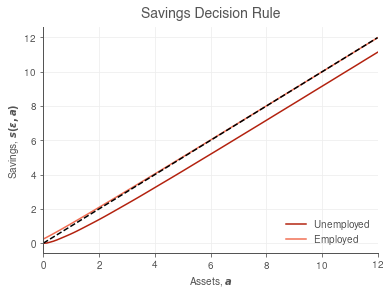

In [16]:
# savings function
plt.figure()
plt.plot(assets_grid_fine.ravel(), assets_prime[0,:],assets_grid_fine.ravel(), assets_prime[1,:],assets_grid_fine.ravel(), assets_grid_fine.ravel(), 'k--' )
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.ylabel(r'Savings, $s(\varepsilon,a)$')
plt.xlim([a_bar,12])
plt.xlabel(r'Assets, $a$')
plt.title('Savings Decision Rule')
plt.legend(('Unemployed', 'Employed'), loc = 'lower right')
plt.grid()
plt.show()


Consumption function:


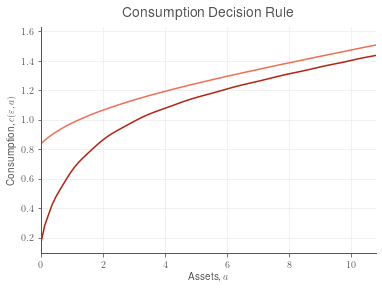

In [17]:
plt.figure()
plt.plot(assets_grid_fine.T, consumption[0,:])
plt.plot(assets_grid_fine.T, consumption[1,:])
plt.xlabel(r'Assets, $a$')
plt.ylabel(r'Consumption, $c(\varepsilon,a)$')
plt.xlim([a_bar,.9*assets_max])
plt.title('Consumption Decision Rule')
plt.legend('Unemployed', 'Employed', loc='bottom right')
plt.grid()

Distribution of unemployed households:

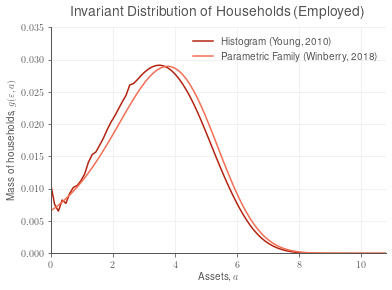

In [21]:
plt.figure()
plt.plot(assets_grid_fine.T, hist_mat[0,:].T/np.sum(hist_mat[0,:],1))
plt.plot(assets_grid_fine.T, density_fine[0,:].T/np.sum(density_fine[0,:]))
plt.xlabel(r'Assets, $a$')
plt.ylabel(r'Mass of households, $g(\varepsilon,a)$')
plt.xlim([a_bar, .9*assets_max])
plt.title('Invariant Distribution of Households (Employed)')
plt.legend(('Histogram (Young, 2010)', 'Parametric Family (Winberry, 2018)'), loc = 'top right')
plt.ylim([0,.035])
plt.grid()
plt.show()

Note the relative lack of mass who are constrained. This is because we are in the base Aiyagari framework, where only ~9.6e-3 and 7e-4 are borrowing constrained in SS. There is a point mass representing this exactly at 0, independent of the grid... however note due to the density being smooth, we don't fully capture this in the assumed form. A slightly different specification around 0 might help with this.

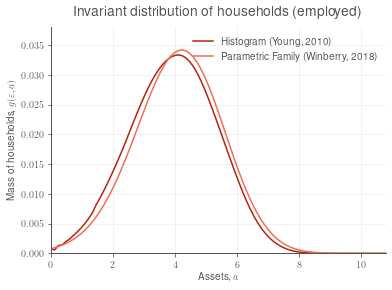

In [22]:
plt.figure()
plt.plot(assets_grid_fine.T, hist_mat[1:2,:].T/np.sum(hist_mat[1:2,:],1))
plt.plot(assets_grid_fine.T, density_fine[1:2,:].T/np.sum(density_fine[1:2,:],1))
plt.xlabel(r'Assets, $a$')
plt.ylabel(r'Mass of households, $g(\varepsilon,a)$')
plt.xlim([a_bar,.9*assets_max])
plt.title('Invariant distribution of households (employed)')
plt.legend(('Histogram (Young, 2010)', 'Parametric Family (Winberry, 2018)'), loc='top right')
plt.ylim([0,.038])
plt.grid()
plt.show()


## Dynamics

First we export our data back to matlab to make it compatible with dynare.

In [42]:
import matlab.engine
import scipy.io.matlab as matl
# saves a .mat file consisting of computed variables for use in dynare
# save as a dictionary containing economic parameters
economic_parameters ={"beta": beta, "sigma": sigma, "a_bar": a_bar, "alpha": alpha, "delta": delta, "vecEpsilonGrid": epsilon_grid, "N": N, "mu": mu, "tau":tau, "rhoTFP": rho_TFP, "sigmaTFP": sigma_TFP, "matEpsilonTransition": epsilon_transition_mat}
matl.savemat('economicParameters.mat', economic_parameters)
# save a dict containing approximation parameters -> .mat file 
approximation_parameters = {'nEpsilon': n_epsilon, 'nAssets': n_assets, 'nStates': n_states, 'assetsMin': assets_min, 'assetsMax': assets_max, 'nAssetsFine': n_assets_fine, 'nStatesFine': n_states_fine, 'nAssetsQuad': n_assets_quad, 'nStatesQuad': n_states_quad}
matl.savemat('approximationParameters.mat', approximation_parameters)
# save a dict containing grids -> .mat file
grids = {'vecAssetsGridZeros': asset_cheb_zeros, 'vecAssetsGrid': assets_grid, 'matEpsilonGrid': epsilon_mat_grid, 'matAssetsGrid': assets_mat_grid, 'matEpsilonPrimeGrid': epsilon_grid_prime, 'vecAssetsGridFine': assets_grid_fine, 'vecAssetsGridFineZeros': assets_grid_fine_zeros, 'matEpsilonGridFine': epsilon_mat_grid_fine, 'matAssetsGridFine': assets_mat_grid_fine, 'matEpsilonPrimeGridFine': epsilon_grid_prime_fine, 'vecQuadWeights': quad_weights_vec, 'vecAssetsGridQuadZeros': assets_grid_quad_zeros, 'vecAssetsGridQuad': assets_grid_quad, 'matEpsilonGridQuad': epsilon_grid_mat_quad, 'matAssetsGridQuad': assets_grid_mat_quad}
matl.savemat('grids.mat', grids)
# save a dict containing polynomials -> .mat file 
polynomials = {'vecAssetsPoly': assets_poly, 'vecAssetsPolySquared': assets_poly_sq, 'vecAssetsPolyFine': assets_poly_fine, 'vecAssetsPolyQuad': assets_poly_quad, 'vecAssetsPolyBC': assets_poly_BC}

Now we run dynare on some dynare specific files with our .mat data we created from the steady state. We could also call octave from within python as well if we wanted instead using `oct2py`

In [39]:
eng = matlab.engine.start_matlab()

In [41]:
eng.

MatlabExecutionError: Too many output arguments.
